In [1]:
from skimage.io import imread
import numpy as np
from scipy.fft import dct, idct
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
import time


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir(f'/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing'

In [4]:
rootfolder =  '/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing/Assignments'

# Denoising

The goal of this section is to implement a simple denoising algorithm based on the 2D DCT. Given a noise free image $Y$, we observe a noisy version $S$:
$$
S = Y + \eta
$$
where $\eta\sim N(0, \sigma^2)$ denotes white Gaussian noise.

Our goal is to compute an estimate $\widehat Y$ of the original image $Y$. To evaluate the performance of the denoising algorithm we use again the PSNR:
$$
\text{PSNR} = 10\log_{10}\frac{1}{\text{MSE}(Y, \widehat Y)}
$$

## Synthetically corrupt an noisy image

Load the image and rescale it in $[0,1]$

In [5]:
img = imread(f'{rootfolder}/data/cameraman.png') / 255  #/data/checkerboard.png
imsz = img.shape

Corrupt the image with white gaussian noise

In [6]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [7]:
def psnr(Y_true, Y_pred):
  mse = np.square(np.subtract(Y_true,Y_pred)).mean()
  #max_signal = np.max(Y_true)
  max_signal = 1
  return 10* np.log10(max_signal**2 / mse)

In [8]:
psnr_noisy = psnr(img, noisy_img)
print(f'PSNR of the noisy image: {psnr_noisy:.2f}')

PSNR of the noisy image: 22.08


Text(0.5, 1.0, 'Noisy image, PSNR = 22.08')

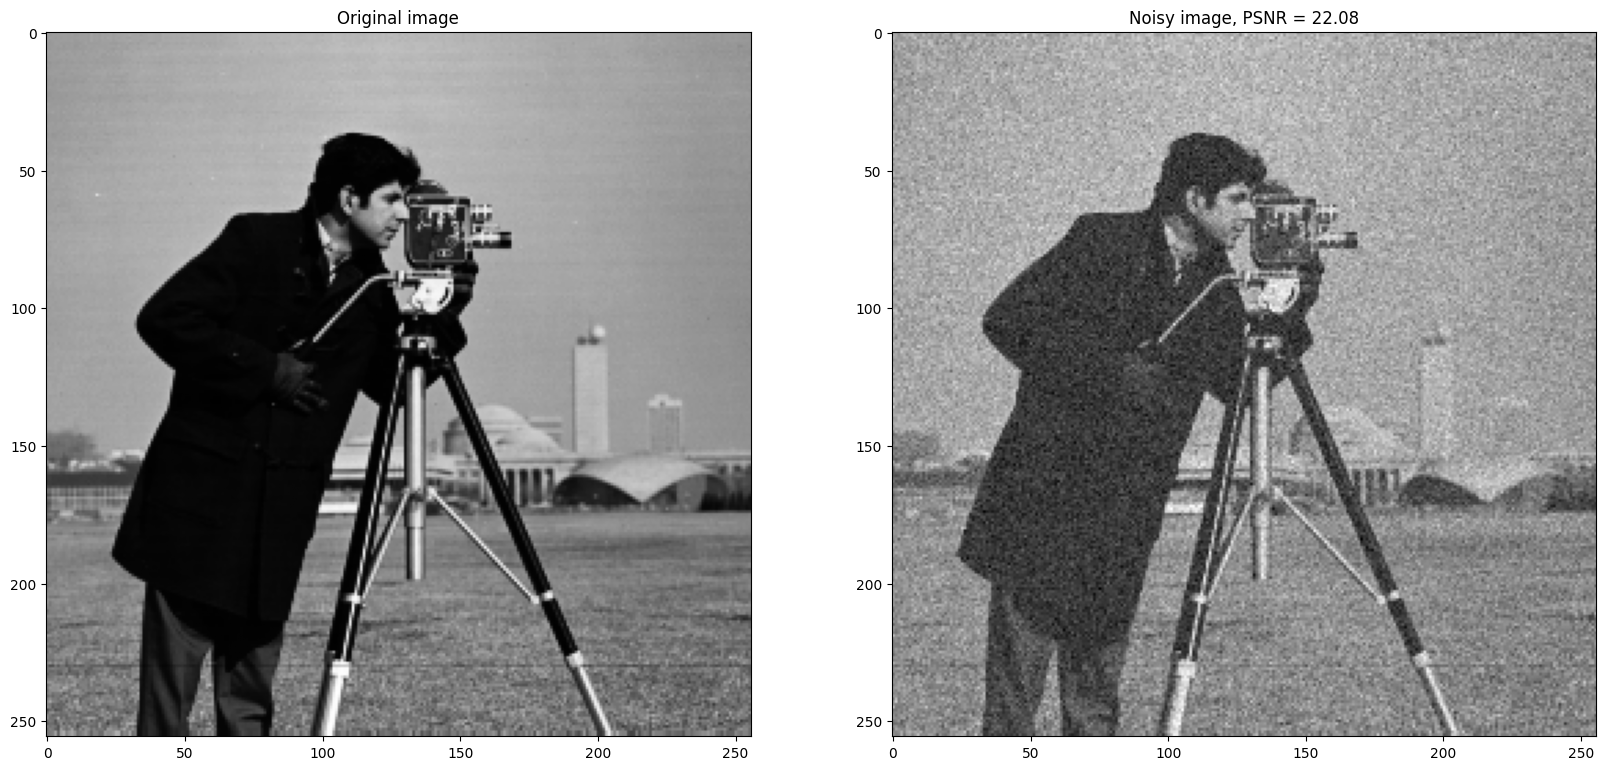

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Noise estimation
----------------
Compute the horizontal derivative of the image

In [24]:
differences = noisy_img[:, 1:] - noisy_img[:, :-1]

Text(0.5, 1.0, 'Differences between adjacent columns')

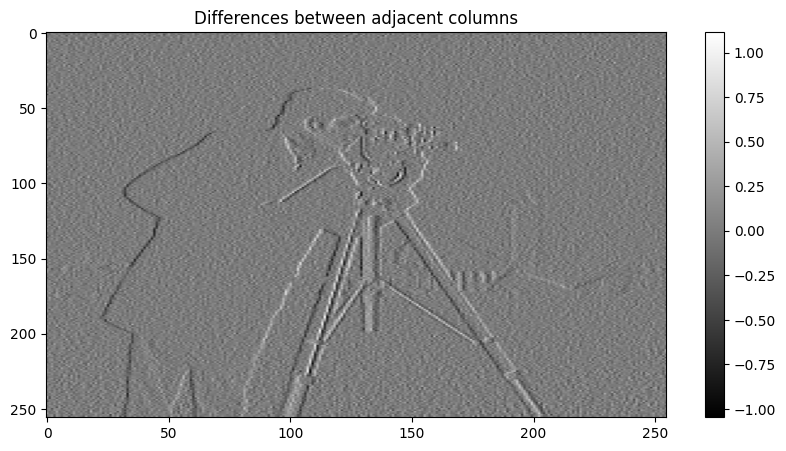

In [20]:
# Plot the differences
plt.figure(figsize=(10, 5))
plt.imshow(differences, cmap='gray', aspect='auto')
plt.colorbar()
plt.title('Differences between adjacent columns')

Compute sigma as the empirical std

In [21]:
sigma_hat_emp = np.divide(np.std(differences), np.sqrt(2))
print(f'sigma_hat (empirical std): {sigma_hat_emp:.3f}')

sigma_hat (empirical std): 0.101


Use MAD to estimate the noise level sigma

In [22]:
gaussian_costant = 0.67449
sigma_hat = np.divide(np.median(np.abs(differences - np.median(differences))), np.sqrt(2)*gaussian_costant)
print(f'sigma_hat (MAD): {sigma_hat:.3f}')

sigma_hat (MAD): 0.087


In [23]:
print(f'sigma: {sigma_noise:.3f}, sigma_hat (empirical std): {sigma_hat_emp:.3f}, sigma_hat (MAD): {sigma_hat:.3f}')

sigma: 0.078, sigma_hat (empirical std): 0.101, sigma_hat (MAD): 0.087


## Denoising by Smoothing
Implement Denoising by Smoothing using convolution against a uniform filter of different size.

In [25]:
def uniform_filter(size):
    return np.ones((size, size)) / (size ** 2)

In [26]:
filter_sizes = [3, 5, 9, 15]
results = []

In [27]:
for filter_size in filter_sizes:
    filter = uniform_filter(filter_size)
    img_hat_conv = convolve2d(noisy_img, filter, mode='same')
    psnr_conv = psnr(img, img_hat_conv)
    results.append((filter_size, psnr_conv))
    print(f'Filter size: {filter_size}, PSNR: {psnr_conv:.2f}')

Filter size: 3, PSNR: 24.28
Filter size: 5, PSNR: 22.09
Filter size: 9, PSNR: 19.99
Filter size: 15, PSNR: 18.35


In [29]:
filter_size = 3

filter = uniform_filter(filter_size)

# compute the convolution with convolve2d()
img_hat_conv = convolve2d(noisy_img, filter, mode='same')

In [30]:
psnr_conv = psnr(img, img_hat_conv)
print(f'Filter size: {filter_size}, PSNR: {psnr_conv:.2f}')

Filter size: 3, PSNR: 24.28


Text(0.5, 1.0, 'Noisy image, PSNR = 22.08')

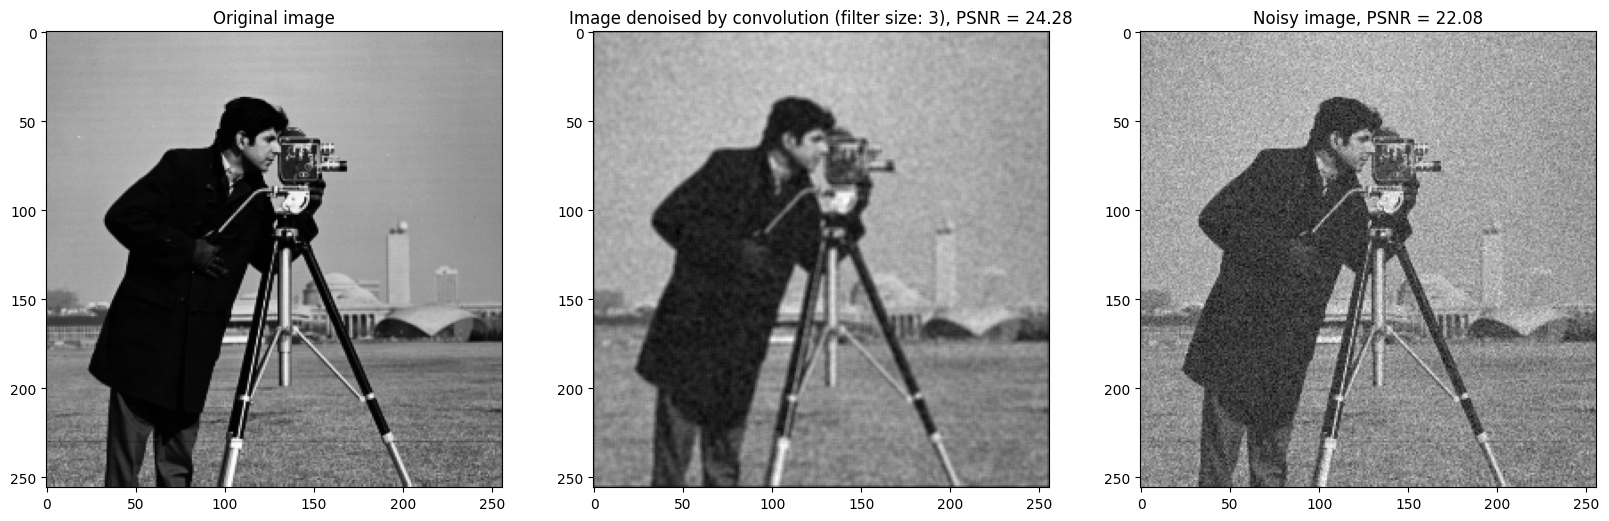

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(img_hat_conv, cmap='gray')
ax[1].set_title(f'Image denoised by convolution (filter size: {filter_size}), PSNR = {psnr_conv:.2f}')

ax[2].imshow(noisy_img, cmap='gray')
ax[2].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')

## Denoising by Leveraging Sparsity in the DCT Domain

Definition of dct2 and idct2 (they are not builtin functions)

In [32]:
def dct2(s):
    return dct(dct(s.T, norm='ortho').T, norm='ortho')

def idct2(x):
    return idct(idct(x.T, norm='ortho').T, norm='ortho')

In [33]:
# patch size
p = 8

# number of elements in the patch
M = p ** 2

Useful function for plot the 2D DCT dictionary

In [34]:
def get_dictionary_img(D):
    M = D.shape[0]
    p = int(round(np.sqrt(M)))
    bound = 2
    img = np.ones((p*p+bound*(p-1), p*p+bound*(p-1)))
    for i in range(M):
        m = np.mod(i, p)
        n = int((i-m)/p)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

DCT denoising
-------------
Generate the DCT basis

In [35]:
D = np.zeros((M, M))
cnt = 0
for i in range(p):
    for j in range(p):
        basis_function = np.zeros((p,p))
        basis_function[i,j] = 1
        D[:, cnt] = idct2(basis_function).flatten()
        cnt = cnt + 1

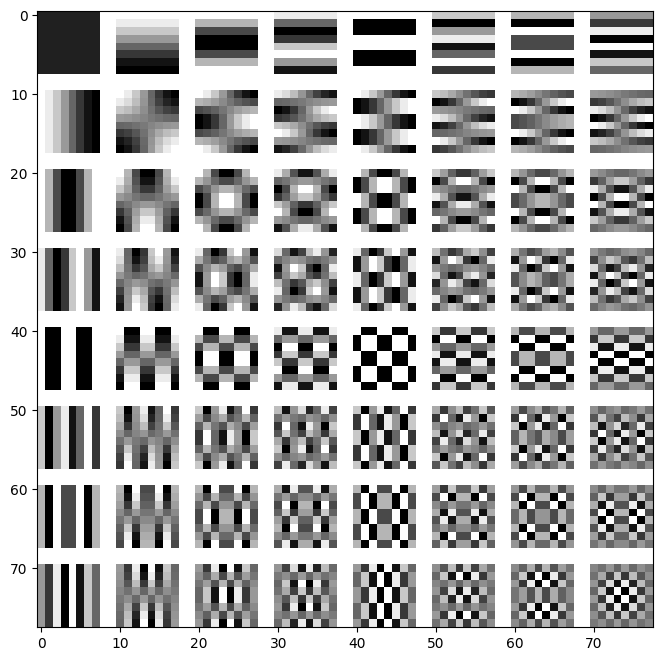

In [36]:
D_img = get_dictionary_img(D)
plt.figure(figsize=(8, 8))
plt.imshow(D_img, cmap='gray')

Denoising: set parameters and initialize the variables

In [43]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# set the threshold for the Hard Thresholding
tau = 3 * sigma_noise # Donoho says: sigma * sqrt(2*log(p^2))

# define the step
STEP = 1

Perform the denoising patchwise

In [44]:
def maximum(a, b):
    if a >= b:
        return a
    else:
        return b

In [45]:
def compute_weights(x_coefficients):
  lower_bound = 1
  non_zero_coefficients = np.count_nonzero(x_coefficients)
  return (1/np.maximum(lower_bound, non_zero_coefficients))

In [46]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p, j:j+p].reshape((M,))

        # compute the representation w.r.t. the 2D DCT dictionary
        x = np.dot(D.T, s)
        #x = dct2(s)

        # perform the hard thresholding (do not perform HT on the DC!)
        x_HT = np.where(np.abs(x) < tau, 0, x)
        x_HT[0] = x[0]

        # perform the reconstruction
        s_hat = np.dot(D, x_HT).reshape((p, p))
        #s_hat = idct2(x_HT)

        # compute the weights to be used for aggregating the reconstructed patch
        w = compute_weights(x_HT)

        # accumulate by summation the denoised patch into the denoised image using the computed weight
        # update img_hat
        img_hat[i:i+p, j:j+p] += w * s_hat

        # accumulate by summation the weights of the current patch in the weight matrix
        # update weights
        weights[i:i+p, j:j+p] += w

Normalize the estimated image with the computed weights, i.e. compute averages

In [47]:
img_hat = np.divide(img_hat, weights)

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image (step: 1), PSNR = 29.24')

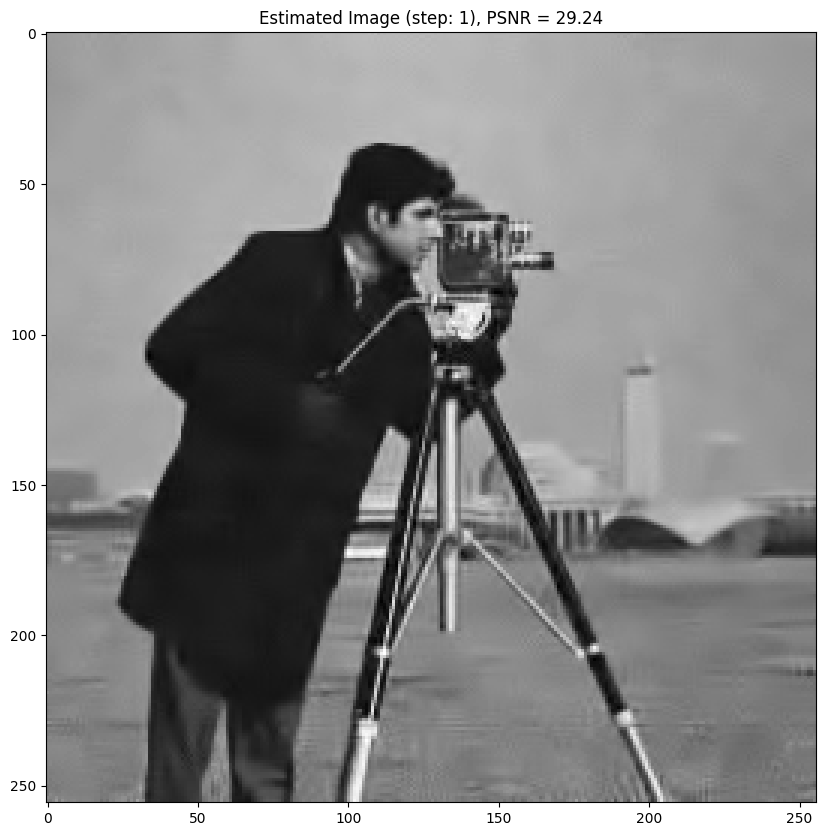

In [48]:
psnr_hat = psnr(img, img_hat)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image (step: {STEP}), PSNR = {psnr_hat:.2f}')


Wiener Filtering
----------------
Initialize the estimated image via Wiener Filtering

In [49]:
img_hat_wiener = np.zeros_like(img)
weights = np.zeros_like(img)

Perform the denoising patchwise

In [50]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch from the noisy image with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p, j:j+p].reshape((M,))

        # compute the representation w.r.t. the 2D DCT dictionary
        x = np.dot(D.T, s)
        #x = dct2(s)

        # extrach the patch from the image estimated by HT with the top left corner at pixel (ii, jj)
        s_hat_HT = img_hat[i:i+p, j:j+p].reshape((M,))

        # compute the representation w.r.t. the 2D DCT dictionary
        x_hat_HT = np.dot(D.T, s_hat_HT)
        #x_hat_HT = dct2(s_hat_HT)

        # perform the Wiener filtering (do not filter the DC!)
        x_wie = ((x_hat_HT**2)/(x_hat_HT**2 + sigma_noise**2)) * x
        x_wie[0] = x_hat_HT[0]

        # perform the reconstruction
        s_hat_wie = np.dot(D, x_wie).reshape((p, p))
        #s_hat_wie = idct2(x_wie)

        # use uniform weights to aggregate the multiple estimates
        w = 1

        # put the denoised patch into the denoised image using the computed weight
        # update img_hat_wiener
        img_hat_wiener[i:i+p, j:j+p] += w * s_hat_wie

        # store the weight of the current patch in the weight matrix
        # update weights
        weights[i:i+p, j:j+p] += w

# Normalize the estimated image with the computed weights
img_hat_wiener = np.divide(img_hat_wiener, weights)

Compute the PSNR of the two estimates

Text(0.5, 1.0, 'Wiener Estimate, PSNR = 29.51')

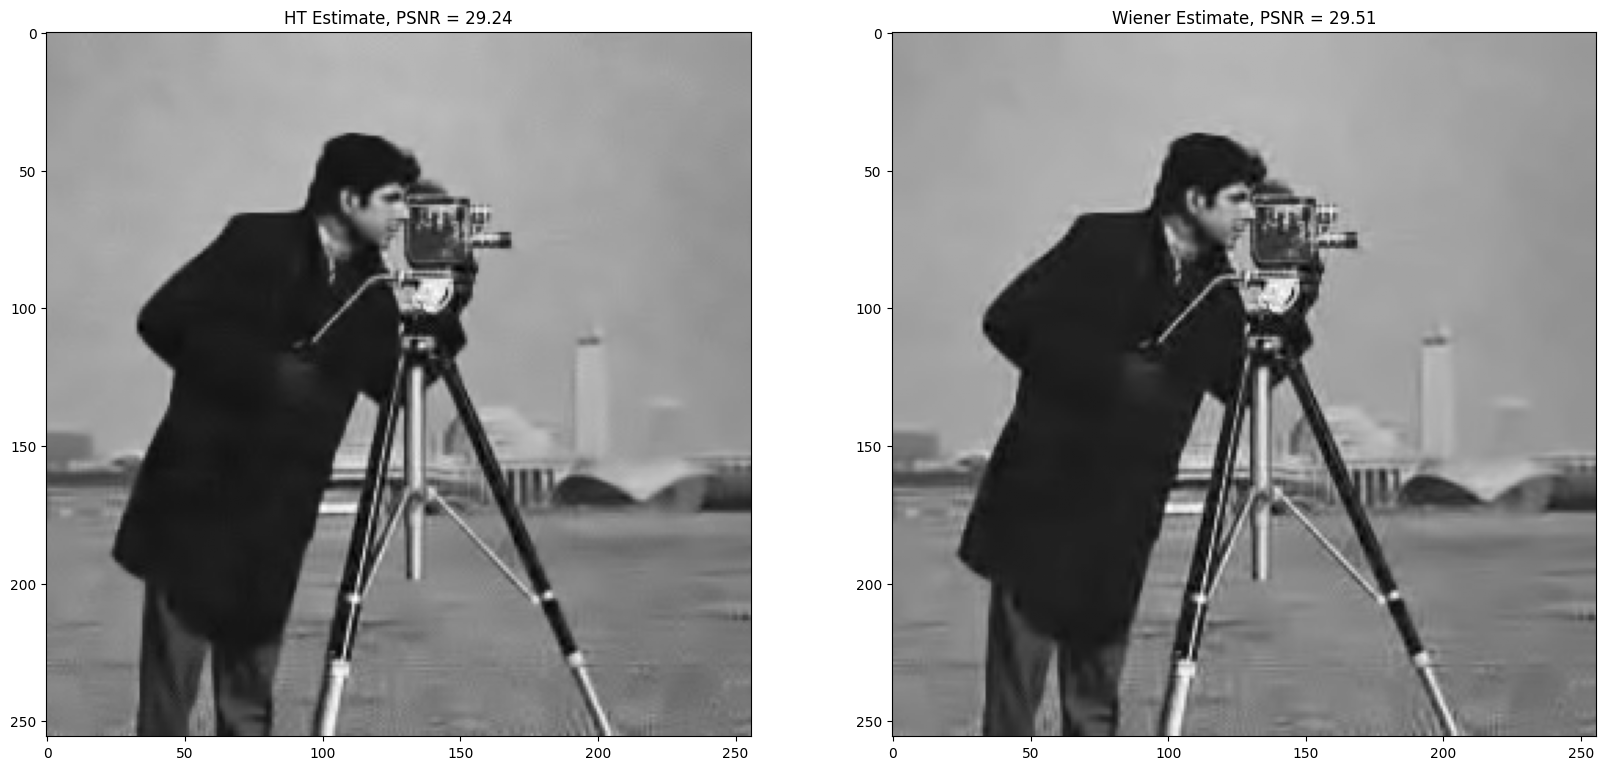

In [52]:
psnr_wiener = psnr(img, img_hat_wiener)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img_hat, cmap='gray')
ax[0].set_title(f'HT Estimate, PSNR = {psnr_hat:.2f}')

ax[1].imshow(img_hat_wiener, cmap='gray')
ax[1].set_title(f'Wiener Estimate, PSNR = {psnr_wiener:.2f}')
